# <span style="color:darkslategray"> Analysis of Visitors in Budapest </span>

### <span style="color:dimgray">Importing packages</span>

In [1]:
# Importing general packages
import pandas as pd
import numpy as np
from dfply import *

# Importing packages for vizualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

# Importing packages for scraping
#!conda install -c conda-forge wikipedia --yes 
import wikipedia
#!conda install -c conda-forge requests --yes 
import requests
#!conda install -c conda-forge bs4 --yes 
from bs4 import BeautifulSoup

# Importing packages for handling gespatial data
import getpass
#!conda install -c conda-forge geocoder --yes 
import geocoder
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim
import folium # map rendering library


### <span style="color:dimgray">Scraping wiki page for data about Budapest's Neighbourhoods </span>

In [2]:
html1 = requests.get('https://en.wikipedia.org/wiki/List_of_districts_in_Budapest')

#turn the HTML into a soup text object
bs1 = BeautifulSoup(html1.text, 'lxml')

In [3]:
#Defining customized replace function
REPLACE_SEQUENCES = ['\n']

def custom_replace(s):
    for to_replace in REPLACE_SEQUENCES:
        s = s.replace(to_replace, '')
    return s.strip()

#Defining a list for the neighbourhoods 
n_list = []

#Filling the list
for i in bs1.find_all(name = 'td'):
    n_list.append(custom_replace(i.get_text()))

#Find the last element of the table of neighbourhoods in the list
matches = [i for i,x in enumerate(n_list) if x=='non-district']

#Dropping elements from the list that is not part of the original wikipedia table
n_list = n_list[0:matches[-1]]
   
#Creating DataFrame from the list
n_list = np.array(n_list)
columns=['District number','District name','Neighborhoods', 'Sights']
df_n = pd.DataFrame(np.reshape(n_list, (int(len(n_list)/4),4)),columns=columns).drop(0)
df_n

,District number,District name,Neighborhoods,Sights
1,I.,Várkerület(Castle District),"Buda Castle, Tabán, Gellérthegy, Krisztinaváro...","Buda Castle, Matthias Church, Hungarian Nation..."
2,II.,none,"Adyliget, Budakeszierdő, Budaliget, Csatárka, ...","Tomb of Gül Baba, Mechwart Park, Cave of Szeml..."
3,III.,Óbuda-Békásmegyer,"Óbuda, Aquincum, Aranyhegy, Békásmegyer, Csill...","Ruins of Aquincum, Aquincum Military Amphithea..."
4,IV.,Újpest(New Pest),"Újpest, Megyer, Káposztásmegyer, Székesdűlő, I...","Queen of Heavens Church, Synagogue of Újpest, ..."
5,V.,Belváros-Lipótváros(Inner City-Leopold Town),"Inner City, Lipótváros","Parliament, Hungarian Academy of Sciences, Gre..."
6,VI.,Terézváros(Theresa Town),Terézváros,"Andrássy Avenue, Hungarian State Opera House, ..."
7,VII.,Erzsébetváros(Elizabeth Town),Erzsébetváros,"Dohány Street Synagogue, Rumbach Street Synago..."
8,VIII.,Józsefváros(Joseph Town),"Józsefváros, Kerepesdűlő, Tisztviselőtelep","Hungarian National Museum, Erkel Theatre, Orcz..."
9,IX.,Ferencváros(Francis Town),"Ferencváros, Gubacsidűlő, József Attila-lakótelep","National Theatre, Palace of Arts, Kálvin Squar..."
10,X.,Kőbánya(Quarry),"Felsőrákos, Gyárdűlő, Keresztúridűlő, Kőbánya-...","Népliget (People's Park), Planetarium, St. Lás..."


### <span style="color:dimgray"> Adding Lat and Long to df </span>

In [4]:
html2 = requests.get('https://hu.wikipedia.org/wiki/Budapest_ker%C3%BCletei')

#turn the HTML into a soup text object
bs2 = BeautifulSoup(html2.text, 'lxml')

In [5]:
# Finding the wikipedia links for Budapest districts and exrtracting them into a list
links = bs2.find("table", class_='wikitable').find_all("a", href=re.compile("/wiki/Budapest_"))

links_final = []
for lines in links:
    links_final.append('https://hu.wikipedia.org' + str(re.findall('"(.*?)"', str(lines))[0]))

In [6]:
longitude = []
latitude = []
for links in links_final:
    html = requests.get(links)

    #turn the HTML into a soup text object
    bs = BeautifulSoup(html.text, 'lxml')

    longitude.append(bs.find("span", class_="p-longitude longitude").text)
    latitude.append(bs.find("span", class_="p-latitude latitude").text)

In [7]:
# Adding geo data to neighbourhood dataframe
df_n['latitude'] = latitude
df_n['longitude'] = longitude
df_n

,District number,District name,Neighborhoods,Sights,latitude,longitude
1,I.,Várkerület(Castle District),"Buda Castle, Tabán, Gellérthegy, Krisztinaváro...","Buda Castle, Matthias Church, Hungarian Nation...",47.4975,19.038055555556
2,II.,none,"Adyliget, Budakeszierdő, Budaliget, Csatárka, ...","Tomb of Gül Baba, Mechwart Park, Cave of Szeml...",47.516666666667,19.016666666667
3,III.,Óbuda-Békásmegyer,"Óbuda, Aquincum, Aranyhegy, Békásmegyer, Csill...","Ruins of Aquincum, Aquincum Military Amphithea...",47.566666666667,19.033333333333
4,IV.,Újpest(New Pest),"Újpest, Megyer, Káposztásmegyer, Székesdűlő, I...","Queen of Heavens Church, Synagogue of Újpest, ...",47.566666666667,19.083333333333
5,V.,Belváros-Lipótváros(Inner City-Leopold Town),"Inner City, Lipótváros","Parliament, Hungarian Academy of Sciences, Gre...",47.5,19.048611111111
6,VI.,Terézváros(Theresa Town),Terézváros,"Andrássy Avenue, Hungarian State Opera House, ...",47.509666666667,19.069833333333
7,VII.,Erzsébetváros(Elizabeth Town),Erzsébetváros,"Dohány Street Synagogue, Rumbach Street Synago...",47.5,19.066666666667
8,VIII.,Józsefváros(Joseph Town),"Józsefváros, Kerepesdűlő, Tisztviselőtelep","Hungarian National Museum, Erkel Theatre, Orcz...",47.489444444444,19.070555555556
9,IX.,Ferencváros(Francis Town),"Ferencváros, Gubacsidűlő, József Attila-lakótelep","National Theatre, Palace of Arts, Kálvin Squar...",47.466666666667,19.083333333333
10,X.,Kőbánya(Quarry),"Felsőrákos, Gyárdűlő, Keresztúridűlő, Kőbánya-...","Népliget (People's Park), Planetarium, St. Lás...",47.481214,19.130303


In [16]:
# Adding credentials for using Foursquare
CLIENT_ID = getpass.getpass('Enter your Foursquare CLIENT_ID')
CLIENT_SECRET = getpass.getpass('Enter your Foursquare CLIENT_SECRET')
VERSION = '20191105'
LIMIT = 100

print('Your credentials are stored')

Enter your Foursquare CLIENT_ID········
Enter your Foursquare CLIENT_SECRET········
Your credentials are stored


In [9]:
#Definging function for using API of Foursquare
def getNearbyVenues(names, latitudes, longitudes, radius=3000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                             'Neighbourhood_Latitude',
                             'Neighbourhood_Longitude',
                             'Venue_ID',
                             'Venue', 
                             'Venue_Latitude',
                             'Venue_Longitude',
                             'Venue_Category']
    
    return(nearby_venues)

In [21]:
# Creating Df by adding vanues to df of Budapest's Neighbourhoods
df_n_ven = getNearbyVenues(df_n['Neighborhoods'], df_n['latitude'], df_n['longitude'], 1500)

len(df_n_ven)

1704

In [11]:
pd.options.display.max_rows = 9999
display(df_n_ven >> group_by(X.Venue_Category) >> summarize(N=n(X.Venue)))

,Venue_Category,N
0,American Restaurant,3
1,Arcade,2
2,Art Gallery,2
3,Art Museum,4
4,Arts & Crafts Store,2
5,Arts & Entertainment,1
6,Asian Restaurant,1
7,Athletics & Sports,5
8,Auto Dealership,1
9,Auto Garage,1


In [22]:
ven_cat = ['Art Gallery', 
           'Art Museum',  
           'Castle', 
           'College Arts Building', 
           'Concert Hall', 
           'Cultural Center',
           'Historic Site', 
           'History Museum', 
           'Monument / Landmark', 
           'Theater']

In [23]:
df_n_ven = df_n_ven[df_n_ven['Venue_Category'].isin(ven_cat)]
df_n_ven = df_n_ven >> distinct(X.Venue)
len(df_n_ven)

41

# Adding credentials again because quota limit for using Foursquare
CLIENT_ID = getpass.getpass('Enter your Foursquare CLIENT_ID')
CLIENT_SECRET = getpass.getpass('Enter your Foursquare CLIENT_SECRET')
VERSION = '20191105'

print('Your credentials are stored')

In [24]:
#Defining function for using API of Foursquare
def getVenuesStat(VenueID):
    
    stats_list=[]
    for ID in VenueID:
        print(ID)   
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            ID, 
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
        print(url)    
        # make the GET request
        results = requests.get(url).json()["response"]['venue']
        
        #Checking whether fields are in JSON and initializing base value      
        likes = []
        stats =[]
        rating = []
        
        if 'likes' in results:
            likes = results['likes']['count']
        else:
            likes = np.nan
        if 'stats' in results:
            stats = results['stats']['tipCount']
        else:
            stats = np.nan
        if 'rating' in results:
            rating = results['rating']
        else:
            rating = np.nan
        
        # return only relevant information for each venue
        stats_list.append([
            ID,
            likes,
            stats,
            rating])
        
        
    #venues_stat = pd.DataFrame([item for stats_list in stats_list for item in stats_list])
    columns = ['Venue_ID', 'likes', 'tipCount', 'rating']
    venues_stat = pd.DataFrame(stats_list, columns=columns)
    
    return(venues_stat)

In [25]:
df_n_ven_stat = getVenuesStat(df_n_ven['Venue_ID'])

4bc9f998937ca59338c2a692
https://api.foursquare.com/v2/venues/4bc9f998937ca59338c2a692?&client_id=RIFAJPXTE0HTYLY2TEEAG0T50JDRRIPEYITFUOI5YNDG2VAE&client_secret=2EWASOVXYAJHVLDIFX2XE112BL0GQUKOK13BBR4VPXQDZH4R&v=20191105
4c1d22e0624b9c740ee61204
https://api.foursquare.com/v2/venues/4c1d22e0624b9c740ee61204?&client_id=RIFAJPXTE0HTYLY2TEEAG0T50JDRRIPEYITFUOI5YNDG2VAE&client_secret=2EWASOVXYAJHVLDIFX2XE112BL0GQUKOK13BBR4VPXQDZH4R&v=20191105
5adb36dee4c459213da14b2e
https://api.foursquare.com/v2/venues/5adb36dee4c459213da14b2e?&client_id=RIFAJPXTE0HTYLY2TEEAG0T50JDRRIPEYITFUOI5YNDG2VAE&client_secret=2EWASOVXYAJHVLDIFX2XE112BL0GQUKOK13BBR4VPXQDZH4R&v=20191105
4d298eccc406721e6a537cb6
https://api.foursquare.com/v2/venues/4d298eccc406721e6a537cb6?&client_id=RIFAJPXTE0HTYLY2TEEAG0T50JDRRIPEYITFUOI5YNDG2VAE&client_secret=2EWASOVXYAJHVLDIFX2XE112BL0GQUKOK13BBR4VPXQDZH4R&v=20191105
4c9cde1b7c096dcb389cc5d1
https://api.foursquare.com/v2/venues/4c9cde1b7c096dcb389cc5d1?&client_id=RIFAJPXTE0HTYLY2TE

4f911d77e4b0b77fb849681a
https://api.foursquare.com/v2/venues/4f911d77e4b0b77fb849681a?&client_id=RIFAJPXTE0HTYLY2TEEAG0T50JDRRIPEYITFUOI5YNDG2VAE&client_secret=2EWASOVXYAJHVLDIFX2XE112BL0GQUKOK13BBR4VPXQDZH4R&v=20191105
53a58e26498e6bfe186ba1f6
https://api.foursquare.com/v2/venues/53a58e26498e6bfe186ba1f6?&client_id=RIFAJPXTE0HTYLY2TEEAG0T50JDRRIPEYITFUOI5YNDG2VAE&client_secret=2EWASOVXYAJHVLDIFX2XE112BL0GQUKOK13BBR4VPXQDZH4R&v=20191105
571a44d2498e21955e2c4ac5
https://api.foursquare.com/v2/venues/571a44d2498e21955e2c4ac5?&client_id=RIFAJPXTE0HTYLY2TEEAG0T50JDRRIPEYITFUOI5YNDG2VAE&client_secret=2EWASOVXYAJHVLDIFX2XE112BL0GQUKOK13BBR4VPXQDZH4R&v=20191105


In [26]:
df_n_ven = df_n_ven.reset_index(drop=True)
df_cult_ven = df_n_ven >> inner_join(df_n_ven_stat, by="Venue_ID")
df_cult_ven >> arrange(X.likes, ascending=False)

,Neighbourhood,Neighbourhood_Latitude,Neighbourhood_Longitude,Venue_ID,Venue,Venue_Latitude,Venue_Longitude,Venue_Category,likes,tipCount,rating
0,"Buda Castle, Tabán, Gellérthegy, Krisztinaváro...",47.4975,19.038055555556,4bc9f998937ca59338c2a692,Budavári Palota,47.496198,19.039543,Castle,2456,227,9.4
3,"Buda Castle, Tabán, Gellérthegy, Krisztinaváro...",47.4975,19.038055555556,4d298eccc406721e6a537cb6,Halászbástya | Fisherman's Bastion (Halászbástya),47.502029,19.035058,Historic Site,1697,272,9.4
34,"Albertfalva, Dobogó, Gazdagrét, Gellérthegy, H...",47.475,19.04,4badd21af964a5205e6b3be3,Citadella,47.486998,19.046345,Historic Site,999,154,9.2
1,"Buda Castle, Tabán, Gellérthegy, Krisztinaváro...",47.4975,19.038055555556,4c1d22e0624b9c740ee61204,Magyar Nemzeti Galéria | Hungarian National Ga...,47.496082,19.039468,Art Museum,688,76,8.9
28,"Ferencváros, Gubacsidűlő, József Attila-lakótelep",47.466666666667,19.083333333333,4b5872a7f964a520415828e3,Müpa Budapest,47.469899,19.071699,Concert Hall,650,43,9.4
22,Terézváros,47.509666666667,19.069833333333,4bb71e0546d4a593a71bc7c0,Vajdahunyad vára,47.515056,19.082844,Castle,583,70,9.0
27,"Józsefváros, Kerepesdűlő, Tisztviselőtelep",47.489444444444,19.070555555556,4bb463380cbcef3bfbee582a,Magyar Nemzeti Múzeum,47.491160,19.062803,History Museum,347,45,8.4
18,Terézváros,47.509666666667,19.069833333333,4b9005abf964a520bb7033e3,Szépművészeti Múzeum,47.516085,19.076493,Art Museum,318,65,8.6
4,"Buda Castle, Tabán, Gellérthegy, Krisztinaváro...",47.4975,19.038055555556,4c9cde1b7c096dcb389cc5d1,Várkert Bazár,47.494343,19.042807,Historic Site,308,29,8.6
14,"Inner City, Lipótváros",47.5,19.048611111111,4bf80dbb508c0f47ad353e31,Katona József Színház,47.493790,19.054791,Theater,299,25,9.3


[Text(0, 0, 'Castle'),
 Text(0, 0, 'Historic Site'),
 Text(0, 0, 'Art Museum'),
 Text(0, 0, 'College Arts Building'),
 Text(0, 0, 'Concert Hall'),
 Text(0, 0, 'Theater'),
 Text(0, 0, 'History Museum'),
 Text(0, 0, 'Art Gallery'),
 Text(0, 0, 'Monument / Landmark')]

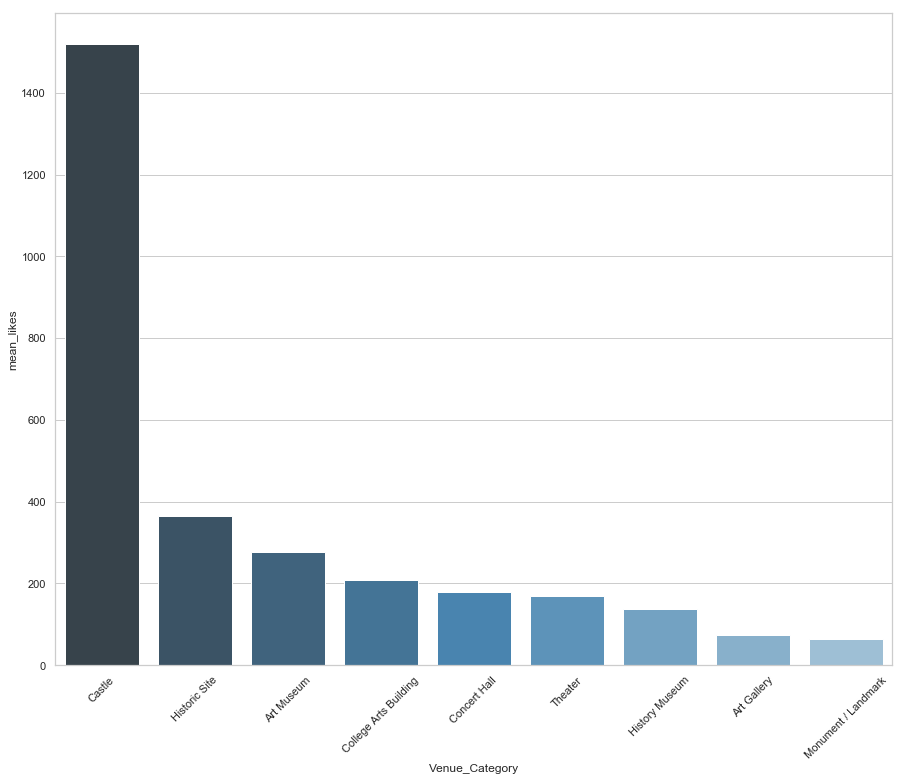

In [27]:
df_cultven_stat = df_cult_ven >> group_by(X.Venue_Category) >> summarize(mean_likes = mean(X.likes), mean_tip = mean(X.tipCount), mean_rating = mean(X.rating)) 
df_cultven_stat = df_cultven_stat.sort_values(['mean_likes'], ascending=False).reset_index(drop=True)
sns.set(style="whitegrid")
plt.figure(figsize=(15,12))
ax = sns.barplot(x="Venue_Category", y="mean_likes", data=df_cultven_stat, palette="Blues_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

[Text(0, 0, 'Castle'),
 Text(0, 0, 'Historic Site'),
 Text(0, 0, 'Art Museum'),
 Text(0, 0, 'History Museum'),
 Text(0, 0, 'Theater'),
 Text(0, 0, 'Art Gallery'),
 Text(0, 0, 'College Arts Building'),
 Text(0, 0, 'Concert Hall'),
 Text(0, 0, 'Monument / Landmark')]

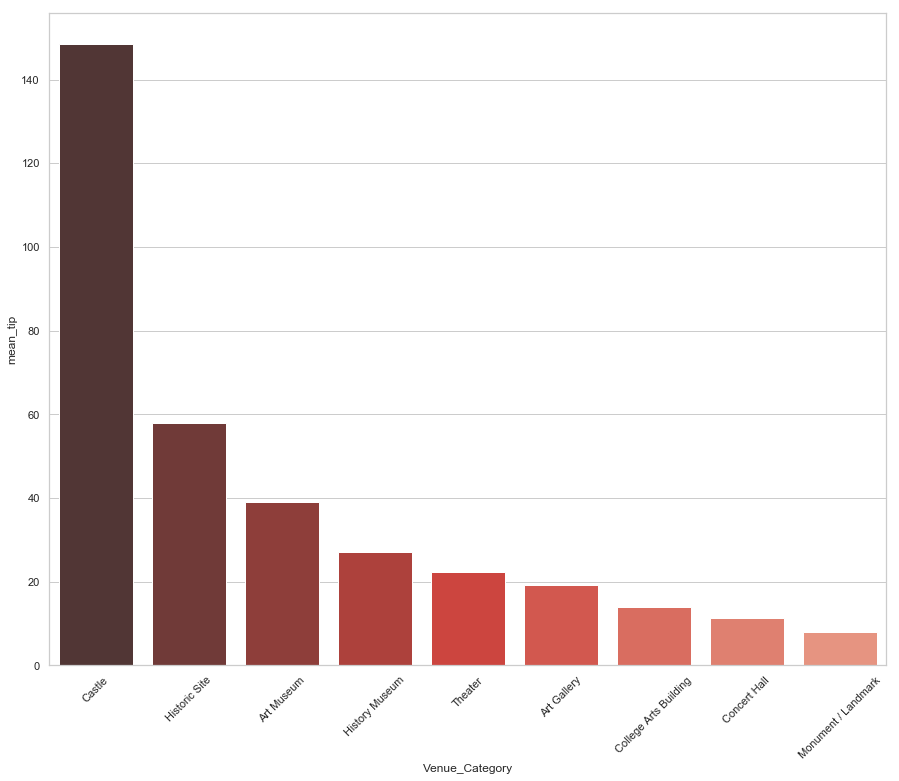

In [28]:
df_cultven_stat = df_cultven_stat.sort_values(['mean_tip'], ascending=False).reset_index(drop=True)
sns.set(style="whitegrid")
plt.figure(figsize=(15,12))
ax = sns.barplot(x="Venue_Category", y="mean_tip", data=df_cultven_stat, palette="Reds_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

[Text(0, 0, 'Castle'),
 Text(0, 0, 'College Arts Building'),
 Text(0, 0, 'Monument / Landmark'),
 Text(0, 0, 'Theater'),
 Text(0, 0, 'Concert Hall'),
 Text(0, 0, 'Historic Site'),
 Text(0, 0, 'Art Gallery'),
 Text(0, 0, 'History Museum'),
 Text(0, 0, 'Art Museum')]

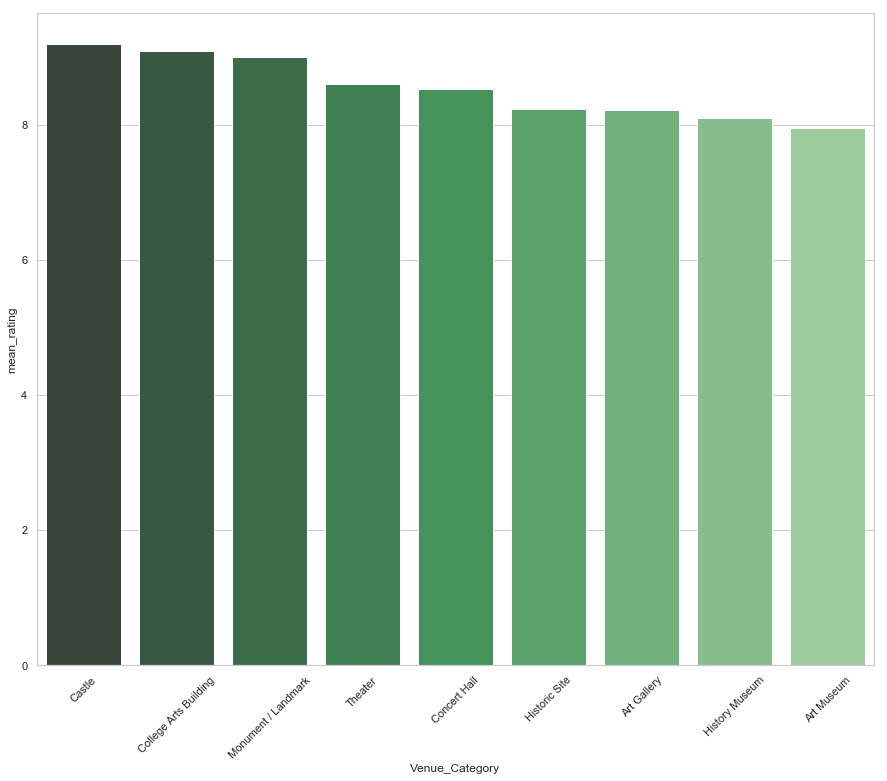

In [29]:
df_cultven_stat = df_cultven_stat.sort_values(['mean_rating'], ascending=False).reset_index(drop=True)
sns.set(style="whitegrid")
plt.figure(figsize=(15,12))
ax = sns.barplot(x="Venue_Category", y="mean_rating", data=df_cultven_stat, palette="Greens_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [30]:
pd.options.display.max_colwidth = 2000
# Grouping by Neighbourhoods
df_neigh = df_cult_ven >> group_by(X.Neighbourhood) >> summarize(n=n(X.Venue_ID)) 
df_neigh.sort_values(by=['n'], ascending=False)


,Neighbourhood,n
12,Terézváros,8
2,"Buda Castle, Tabán, Gellérthegy, Krisztinaváros, southern Víziváros",7
7,"Ferencváros, Gubacsidűlő, József Attila-lakótelep",4
8,"Inner City, Lipótváros",4
0,"Adyliget, Budakeszierdő, Budaliget, Csatárka, Erzsébetliget, Erzsébettelek, Felhévíz, Gercse, Hársakalja, Hárshegy, Hűvösvölgy, Kővár, Kurucles, Lipótmező, Máriaremete, Nyék, Országút, Pálvölgy, Pasarét, Pesthidegkút-Ófalu, Petneházy-rét, Remetekertváros, Rézmál, Rózsadomb, Szemlőhegy, Széphalom, Szépilona, Szépvölgy, Törökvész, Újlak, Vérhalom, northern Víziváros, Zöldmál.",2
4,"Budatétény, Nagytétény, Budafok",2
5,Erzsébetváros,2
6,"Felsőrákos, Gyárdűlő, Keresztúridűlő, Kőbánya-Kertváros",2
9,"Józsefváros, Kerepesdűlő, Tisztviselőtelep",2
13,"Óbuda, Aquincum, Aranyhegy, Békásmegyer, Csillaghegy, Csúcshegy, Filatorigát, Hármashatár-hegy, Kaszásdűlő, Mátyáshegy, Mocsárosdűlő, Óbudai-sziget, Remetehegy, Rómaifürdő, Solymárvölgy, Szépvölgy, Táborhegy, Testvérhegy, Törökkő, Ürömhegy, Újlak.",2


In [41]:
color_theme = {
    'Buda Castle, Tabán, Gellérthegy, Krisztinaváros, southern Víziváros': 'red',
    'Terézváros': 'blue',
    'Adyliget, Budakeszierdő, Budaliget, Csatárka, Erzsébetliget, Erzsébettelek, Felhévíz, Gercse, Hársakalja, Hárshegy, Hűvösvölgy, Kővár, Kurucles, Lipótmező, Máriaremete, Nyék, Országút, Pálvölgy, Pasarét, Pesthidegkút-Ófalu, Petneházy-rét, Remetekertváros, Rézmál, Rózsadomb, Szemlőhegy, Széphalom, Szépilona, Szépvölgy, Törökvész, Újlak, Vérhalom, northern Víziváros, Zöldmál.': 'green',
    'Ferencváros, Gubacsidűlő, József Attila-lakótelep': 'orange', 
    'Újpest, Megyer, Káposztásmegyer, Székesdűlő, Istvántelek.': 'darkred',
    'Óbuda, Aquincum, Aranyhegy, Békásmegyer, Csillaghegy, Csúcshegy, Filatorigát, Hármashatár-hegy, Kaszásdűlő, Mátyáshegy, Mocsárosdűlő, Óbudai-sziget, Remetehegy, Rómaifürdő, Solymárvölgy, Szépvölgy, Táborhegy, Testvérhegy, Törökkő, Ürömhegy, Újlak.': 'gray', 
    'Rákospalota, Pestújhely, Újpalota': 'purple', 
    'Albertfalva, Dobogó, Gazdagrét, Gellérthegy, Hosszúrét, Kamaraerdő, Kelenföld, Kelenvölgy, Kőérberek, Lágymányos, Madárhegy, Őrmező, Örsöd, Péterhegy, Pösingermajor, Sasad, Sashegy, Spanyolrét, Tabán': 'darkpurple', 
    'Alsórákos, Herminamező, Istvánmező, Kiszugló, Nagyzugló, Rákosfalva, Törökőr, City Park': 'lightgray', 
    'Budatétény, Nagytétény, Budafok': 'black',
    'Budakeszierdő, Csillebérc, Farkasrét, Farkasvölgy, Istenhegy, Jánoshegy, Kissvábhegy, Krisztinaváros, Kútvölgy, Magasút, Mártonhegy, Németvölgy, Orbánhegy, Sashegy, Svábhegy, Széchenyihegy, Virányos.': 'lightblue',
    'Felsőrákos, Gyárdűlő, Keresztúridűlő, Kőbánya-Kertváros': 'beige', 
    'Inner City, Lipótváros': 'pink',
    'Erzsébetváros': 'black',
    'Józsefváros, Kerepesdűlő, Tisztviselőtelep': 'darkred', 
    'Mátyásföld, Sashalom, Cinkota, Rákosszentmihály, Árpádföld, Kisszentmihály, Ilonatelep, Petőfikert, Nagyiccetelep, Szentgyörgytelep, Szabadságtelep, Huszkatelep': 'darkgreen', 
    'Rákoskeresztúr, Rákoscsaba, Rákoscsaba-Újtelep, Rákosliget, Rákoshegy, Rákoskert, Akadémiaújtelep, Madárdomb, Régiakadémiatelep': 'lightred', 
    'Újlipótváros, Angyalföld, Vizafogó, Népsziget, Göncz Árpád városközpont': 'cadetblue'}

color_dict = pd.DataFrame.from_dict(color_theme, orient='index')
color_dict = color_dict.reset_index()
color_dict = color_dict.rename(columns={"index": "Neighbourhood", 0: "Color"})

df_cult_ven = df_cult_ven.reset_index(drop=True)
df_cult_ven = df_cult_ven >> drop(X.Color)
df_cult_ven = df_cult_ven >> left_join(color_dict, by='Neighbourhood')
df_cult_ven['Color'] = df_cult_ven['Color'].fillna('lightgray')
df_cult_ven

,Neighbourhood,Neighbourhood_Latitude,Neighbourhood_Longitude,Venue_ID,Venue,Venue_Latitude,Venue_Longitude,Venue_Category,likes,tipCount,rating,Color
0,"Buda Castle, Tabán, Gellérthegy, Krisztinaváros, southern Víziváros",47.4975,19.038055555556,4bc9f998937ca59338c2a692,Budavári Palota,47.496198,19.039543,Castle,2456,227,9.4,red
1,"Buda Castle, Tabán, Gellérthegy, Krisztinaváros, southern Víziváros",47.4975,19.038055555556,4c1d22e0624b9c740ee61204,Magyar Nemzeti Galéria | Hungarian National Gallery (Magyar Nemzeti Galéria),47.496082,19.039468,Art Museum,688,76,8.9,red
2,"Buda Castle, Tabán, Gellérthegy, Krisztinaváros, southern Víziváros",47.4975,19.038055555556,5adb36dee4c459213da14b2e,Budavári Mikve,47.498546,19.035846,Historic Site,16,0,8.3,red
3,"Buda Castle, Tabán, Gellérthegy, Krisztinaváros, southern Víziváros",47.4975,19.038055555556,4d298eccc406721e6a537cb6,Halászbástya | Fisherman's Bastion (Halászbástya),47.502029,19.035058,Historic Site,1697,272,9.4,red
4,"Buda Castle, Tabán, Gellérthegy, Krisztinaváros, southern Víziváros",47.4975,19.038055555556,4c9cde1b7c096dcb389cc5d1,Várkert Bazár,47.494343,19.042807,Historic Site,308,29,8.6,red
5,"Buda Castle, Tabán, Gellérthegy, Krisztinaváros, southern Víziváros",47.4975,19.038055555556,4c51a1ab3940be9ae8852e09,Sziklakórház (Sziklakórház és Atombunker),47.500652,19.031667,History Museum,195,60,8.4,red
6,"Buda Castle, Tabán, Gellérthegy, Krisztinaváros, southern Víziváros",47.4975,19.038055555556,4c58143030d82d7f8d2ddb62,Bécsi Kapu,47.505015,19.030654,Monument / Landmark,64,8,9.0,red
7,"Adyliget, Budakeszierdő, Budaliget, Csatárka, Erzsébetliget, Erzsébettelek, Felhévíz, Gercse, Hársakalja, Hárshegy, Hűvösvölgy, Kővár, Kurucles, Lipótmező, Máriaremete, Nyék, Országút, Pálvölgy, Pasarét, Pesthidegkút-Ófalu, Petneházy-rét, Remetekertváros, Rézmál, Rózsadomb, Szemlőhegy, Széphalom, Szépilona, Szépvölgy, Törökvész, Újlak, Vérhalom, northern Víziváros, Zöldmál.",47.516666666667,19.016666666667,4cab53f1f47ea14363c18a21,Gül Baba Türbéje,47.515896,19.034629,Historic Site,166,48,8.2,green
8,"Adyliget, Budakeszierdő, Budaliget, Csatárka, Erzsébetliget, Erzsébettelek, Felhévíz, Gercse, Hársakalja, Hárshegy, Hűvösvölgy, Kővár, Kurucles, Lipótmező, Máriaremete, Nyék, Országút, Pálvölgy, Pasarét, Pesthidegkút-Ófalu, Petneházy-rét, Remetekertváros, Rézmál, Rózsadomb, Szemlőhegy, Széphalom, Szépilona, Szépvölgy, Törökvész, Újlak, Vérhalom, northern Víziváros, Zöldmál.",47.516666666667,19.016666666667,51290404e4b0d0a7c976643e,Jurányi Színházterem,47.508351,19.030243,Theater,18,4,8.2,green
9,"Óbuda, Aquincum, Aranyhegy, Békásmegyer, Csillaghegy, Csúcshegy, Filatorigát, Hármashatár-hegy, Kaszásdűlő, Mátyáshegy, Mocsárosdűlő, Óbudai-sziget, Remetehegy, Rómaifürdő, Solymárvölgy, Szépvölgy, Táborhegy, Testvérhegy, Törökkő, Ürömhegy, Újlak.",47.566666666667,19.033333333333,4c051363187ec928e3dbb77b,Aquincum,47.563757,19.049360,Historic Site,37,13,6.0,gray


In [42]:
m = folium.Map(
    location=[47.498333, 19.040833],
    zoom_start=12
)

for lat, long, name, color in zip(df_cult_ven['Venue_Latitude'],
                                           df_cult_ven['Venue_Longitude'],
                                           df_cult_ven['Venue'],
                                           df_cult_ven['Color']):
    
    folium.Marker(
        location=[lat, long],
        popup=name,
        icon=folium.Icon(color=color)
    ).add_to(m)

m